## 初始化与计算

In [3]:
import os,sys
import numpy as np

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import os
from scipy.optimize import curve_fit
import inspect

def read_sys_json(path):
    """
    从指定路径读取系统参数 JSON 文件
    参数:
    path (str): 包含 JSON 文件的目录路径。
    返回:
    dict: 包含系统参数数据的 dict
    """
    import json
    file_path = path
    try:
        # 以只读模式打开 JSON 文件
        with open(file_path, 'r', encoding='utf-8') as file:
            # 读取 JSON 文件内容并转换为字典
            data_dict = json.load(file)
            for key,value in data_dict.items():
                if type(value)==float:
                    print(key,': {:,}'.format(value))
                else:
                    print(key,':',value)
        return data_dict
    except FileNotFoundError:
        print(f"未找到文件: {file_path}")
    except json.JSONDecodeError:
        print(f"文件 {file_path} 不是有效的 JSON 格式。")

def read_id900_binary(path,channel):
    """
    从指定路径读取特定通道的二进制文件，并将其转换为 Pandas DataFrame。

    参数:
    path (str): 包含二进制文件的目录路径。
    channel (int): 要读取的通道号。

    返回:
    pandas.DataFrame: 包含二进制文件数据的 DataFrame,列名为 'time_satmp' 和 'start_index'。
    None: 如果未找到指定通道的二进制文件。
    """
    
    for file_name in os.listdir(path):
        if 'C{}'.format(channel) in file_name:
            pmt_array=np.fromfile('{}/{}'.format(path,file_name),dtype=np.uint64).reshape(-1,2)
            pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
            return pmt_pd
    print('No channel {} bin file found'.format(channel))
    return None

def read_id900_binary_from_file(file_path,start_index=True):
    """
    从指定路径读取特定通道的二进制文件，并将其转换为 Pandas DataFrame。

    参数:
    path (str): 包含二进制文件的目录路径。

    返回:
    pandas.DataFrame: 包含二进制文件数据的 DataFrame,列名为 'time_satmp' 和 'start_index'。
    None: 如果未找到指定通道的二进制文件。
    """
    if start_index:
        pmt_array=np.fromfile(file_path,dtype=np.uint64).reshape(-1,2)
        pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
        return pmt_pd
    else:
        pmt_array=np.fromfile(file_path,dtype=np.uint64)
        pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp'])
        pmt_pd=pmt_pd.astype(np.int64)
        pmt_pd['start_index']=np.sign(pmt_pd.diff())
        pmt_pd.loc[0,'start_index']=-1
        pmt_pd.loc[pmt_pd['start_index']==1,'start_index']=0  
        pmt_pd.loc[pmt_pd['start_index']==-1,'start_index']=1
        pmt_pd['start_index']=pmt_pd['start_index'].cumsum()
        return pmt_pd


def window_index(df, start, end, pulse_num=1, pulse_interval=5e6):
    """
    生成一个布尔索引，用于筛选出指定数据框中时间戳在一系列时间窗口内的行。

    参数:
    df (pandas.DataFrame): 输入的数据框，包含 'time_satmp' 和 'start_index' 列。
    start (int or float): 第一个时间窗口的起始时间。
    end (int or float): 第一个时间窗口的结束时间。
    pulse_num (int, 可选): 脉冲的数量，默认为 1。
    pulse_interval (float, 可选): 相邻时间窗口之间的间隔[ps]，默认为 5us。

    返回:
    pandas.Series: 一个布尔索引，用于筛选出符合条件的行。
    """
    # 初始化一个布尔索引，所有元素初始化为 False
    _index = df['start_index'] < 0
    # 循环生成多个时间窗口的布尔索引
    for pulse_i in range(pulse_num):
        # 计算当前时间窗口的起始和结束时间
        _window_start = start + pulse_i * pulse_interval
        _window_end = end + pulse_i * pulse_interval
        # 生成当前时间窗口的布尔索引，并累加到总索引上
        _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)
    return _index


def count2gamma(df):
    """
    该函数用于将 PMT 计数数据转换为 gamma 值、gamma 误差和相位值。

    参数:
    df (pandas.DataFrame): 包含 PMT 计数数据的 DataFrame，应包含 'pmt1'、'pmt2' 和 'turn' 列。

    返回:
    pandas.DataFrame: 包含计算后的 'gamma'、'gamma_err' 和 'phase' 列的 DataFrame。
    """
    # 计算 gamma 值，公式为 (pmt1 - pmt2) / (pmt1 + pmt2)
    df['gamma']=(df['pmt1']-df['pmt2'])/(df['pmt1']+df['pmt2'])
    # 计算 gamma 误差的平方，公式为 (2 * pmt2 / ((pmt1 + pmt2) ** 2) * sqrt(pmt1)) ** 2 + (-2 * pmt1 / ((pmt1 + pmt2) ** 2) * sqrt(pmt2)) ** 2
    df['gamma_err']=(2*df['pmt2']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt1']))**2+(-2*df['pmt1']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt2']))**2
    # 对 gamma 误差的平方取平方根，得到 gamma 误差
    df['gamma_err']=np.sqrt(df['gamma_err'])
    # 计算相位值，公式为 turn * 360 * 2
    df['phase']=df['turn']*360*2



# 定义模型函数：正弦波
def model_func_count_offset(x, gamma, phase_offset,count_offset):
    """
    A sin(x + phi) + B
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))+count_offset

def model_func_sin(x, gamma, phase_offset):
    """
    A sin(x + phi)
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))


# 生成数据点
def estimate_gamma(df,model_func=model_func_count_offset):
    """  A cos(df + B)
    return estimate [A,B]"""
    x_data = df['turn']*360*2  # x轴数据
    y_data = df['gamma']  # y轴数据
    y_err = df['gamma_err']  # y轴数据误差
    pmt1 = df['pmt1']
    pmt2 = df['pmt2']
    x_data_arange = np.linspace(0, 360*2, 200)  # 生成更多数据点用于拟合
    # 使用curve_fit进行非线性最小二乘法拟合
    # 定义参数的下界和上界
    # 获取函数的参数信息
    sig = inspect.signature(model_func)
    # 获取参数的数量
    param_count = len(sig.parameters)
    if param_count == 2+1:
        lower_bounds = [0, 0]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    elif param_count == 3+1:
        lower_bounds = [0, 0,-0.1]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi,0.2]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    else:
        print('model_func has {} parameters, but only 2 or 3 parameters are supported'.format(param_count))
        params, covariance = curve_fit(model_func, x_data, y_data,sigma=y_err)

    # 使用拟合参数计算预测值
    y_pred = model_func(x_data, *params)

    # 计算R²
    mean_y = np.mean(y_data)
    total_variance = np.sum((y_data - mean_y) ** 2)
    residual_variance = np.sum((y_data - y_pred) ** 2)
    r_squared = 1 - (residual_variance / total_variance)
    # 输出拟合参数
    if param_count == 2+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, R²={r_squared:.3%}")
    elif param_count == 3+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, count_offset={params[2]:.3f}±{np.sqrt(np.diag(covariance))[2]:.3f}, R²={r_squared:.3%}")

    # 绘制原始数据点和拟合曲线
    plt.subplot(211)
    plt.errorbar(x_data,pmt1,fmt='-o',yerr=np.sqrt(pmt1),label='pmt1',capsize=5)
    plt.errorbar(x_data,pmt2,fmt='-o',yerr=np.sqrt(pmt2),label='pmt2',capsize=5)
    plt.plot(x_data,(pmt1+pmt2)/2, 'x-.', label='(pmt1+pmt2)/2')
    plt.xlim(0,360*2)
    plt.xlabel('phase offset with 729 OAM turn [°]')
    plt.ylabel('pmt counts')
    plt.title('PMT count, experimental error estimate by shot noise')
    plt.legend(loc=1)
    plt.grid()
    plt.subplot(212)
    plt.errorbar(x_data, (y_data), fmt='o', label='experimental data',yerr=y_err,capsize=5)
    plt.plot(x_data_arange,(model_func(x_data_arange, *params)), '-', label='fit {:.1%}±{:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0]))
    plt.xlabel('phase offset with 729 OAM turn [°] {:+.2f}°'.format(params[1]/np.pi*180))
    plt.ylabel('estimae gamma')
    plt.title('LS estimae $\\gamma$: {:.3%}±{:.3%}, $R^2=${:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0],r_squared))
    plt.xlim(0,360*2)
    plt.legend(loc=1)
    plt.grid()
    plt.tight_layout()
    params_err=np.sqrt(np.diag(covariance))

    return params,params_err

In [4]:
fold=os.listdir('./')
turns=[]
for i,_ in enumerate(fold):
    try:
        "{}".format(float(_.split('_')[0]))
        turns.append(_)
    except:
        pass
    print(i,_)
print(str(turns).replace('\'','"'))

0 gamma_res_time.csv
1 gamma_fit.jpeg
2 fig_sm_5b.ipynb
[]


### 计算光子数

In [ ]:
sys_json = read_sys_json('sys.json')

# 荧光计数窗口
window_start = sys_json['window_start(ps)']
window_end = sys_json['window_end(ps)']
# 分析数据截至时间
period = sys_json['period(s)']
time_start = sys_json['time_start(s)']
time_stop = sys_json['time_stop(s)']
# 脉冲
pulse_num = sys_json['pulse_num']
pulse_interval = sys_json['pulse_interval(ps)']
# 相位
turn = sys_json['turns'][-1]
# 外层计数验证
threshold = sys_json['threshold']
inner_loop = sys_json['inner_loop']
start_index = (sys_json['start_index']>0)


In [ ]:
for turn in turns:
    for _ in os.listdir(os.path.join('',turn)):
        if _.endswith('.bin') and 'C3' in _:
            bin_path=os.path.join('',turn,_)

            # bin_path=r'SP_0_10km_Inter_0.371turns_C3_2025-09-07T22_50_48.bin'
            pmt1_df=read_id900_binary_from_file(bin_path,start_index=start_index)
            pmt2_df=read_id900_binary_from_file(bin_path.replace('C3','C4'),start_index=start_index)

            ## 添加反映数据是否因为离子雾化需要删除的序列
            # pmt1_df['delete'] = np.logical_not(np.isin(pmt1_df['start_index'], drop_inner_index))
            # pmt2_df['delete'] = np.logical_not(np.isin(pmt2_df['start_index'], drop_inner_index))
            # ## 时间限制
            # pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
            # pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)&pmt1_df['delete']].copy()
            pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)].copy()
            pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)].copy()
            ## 计算时间窗内光子数
            pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
            pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
            pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
            pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
            PMT1_SUM=pmt1_count.sum()
            PMT2_SUM=pmt2_count.sum()
            print('pmt1:{}, pmt2:{}'.format(PMT1_SUM,PMT2_SUM))
            max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
            print('cps1:{}, cps2:{}'.format(PMT1_SUM/max_time,PMT2_SUM/max_time))

            out_csv='gamma_res_time.csv'
            try:
                with open(out_csv, 'r') as f:
                    pass
            except FileNotFoundError:
                # 文件不存在，写入标题
                with open(out_csv, 'w') as f:
                    f.write('turn,state,start(ps),end(ps),pmt1,pmt2,g,phase\n')

            with open(out_csv,'a') as f:
                f.write('{a},origin,{t0:.0f},{t1:.0f},{pmt1:.0f},{pmt2:.0f},{g:.2%},{phase:.0f}\n'.format(a=turn.split('_')[0],t0=window_start,t1=window_end,pmt1=PMT1_SUM,pmt2=PMT2_SUM,g=(PMT1_SUM-PMT2_SUM)/(PMT1_SUM+PMT2_SUM),phase=float(turn.split('_')[0])*360*2))


# Estimate gamma

In [ ]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']

-------------origin data-----------------
Fitted parameters: gamma=0.975±0.007, phase_offset=3.210±0.025, count_offset=-0.004±0.006, R²=99.865%


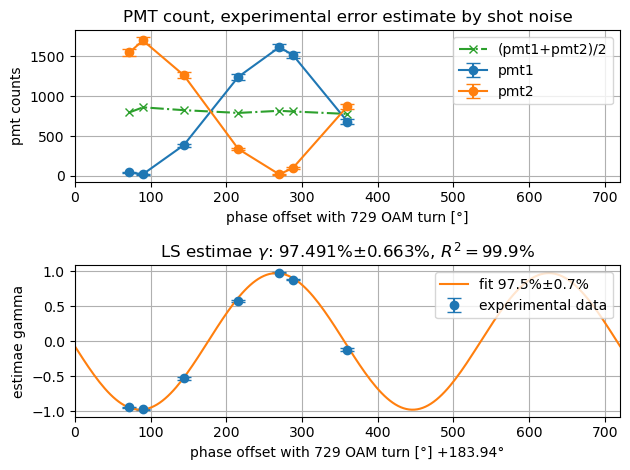

In [9]:
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
monitor_df=res_data[res_data['state']=='monitor']
print('-------------origin data-----------------')
param_origin,param_origin_err=estimate_gamma(origin_df,model_func=model_func_count_offset)
plt.savefig('gamma_fit.jpeg', dpi=300)
plt.show()
# print('-------------Ref data-----------------')
# param_monitor,param_monitor_err=estimate_gamma(monitor_df,model_func=model_func_sin)
# plt.savefig('gamma_fit_ref.jpeg', dpi=300)
# plt.show()

comment : This is a json file for TDC count.
blcok0 : count windows info
window_start(ps) : 250,000.0
window_end(ps) : 330,000.0
block1 : recquire time info
period(s) : 0.0005
time_start(s) : 0
time_stop(s) : 4000
block2 : pulse info
pulse_num : 1
pulse_interval(ps) : 65,000,000.0
block3 : turn / phase info
turns : ['0.125', '0.5', '0.375', '0.1', '0.2', '0.3', '0.4']
block4 : windwo move info
window_start_list(ns) : [620, 622, 624]
window_len(ns) : 4
block5 : monitor pulse info
monitor_start(ps) : 45441800
monitor_end(ps) : 45443000
block6 : outer count info
threshold : 1
inner_loop : 1000000
start_index : 1
pmt1:21, pmt2:1699
cps1:0.21005671531313455, cps2:16.994588538905504


/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_13904/4264422568.py:108: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)


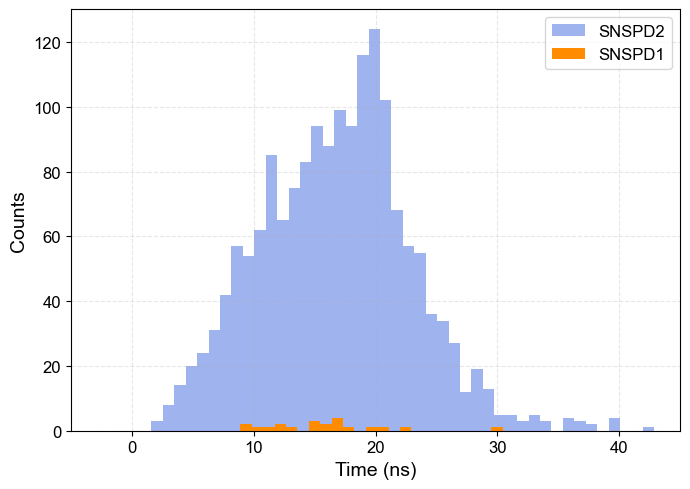

In [54]:
#fig2d inset
sys_json = read_sys_json('sys.json')

# 荧光计数窗口
window_start = sys_json['window_start(ps)']
window_end = sys_json['window_end(ps)']
# 分析数据截至时间
period = sys_json['period(s)']
time_start = sys_json['time_start(s)']
time_stop = sys_json['time_stop(s)']
# 脉冲
pulse_num = sys_json['pulse_num']
pulse_interval = sys_json['pulse_interval(ps)']
# 相位
turn = '0.125'
# 外层计数验证
threshold = sys_json['threshold']
inner_loop = sys_json['inner_loop']
start_index = (sys_json['start_index']>0)

drop_inner_index = np.array(0)

for _ in os.listdir(turn):
    if _.endswith('.bin') and 'C3' in _:
        bin_path=os.path.join(turn,_)

pmt1_df=read_id900_binary_from_file(bin_path,start_index=start_index)
pmt2_df=read_id900_binary_from_file(bin_path.replace('C3','C4'),start_index=start_index)

pmt1_df=pmt1_df[(pmt1_df['start_index']>=time_start/period)&(pmt1_df['start_index']<=time_stop/period)].copy()
pmt2_df=pmt2_df[(pmt2_df['start_index']>=time_start/period)&(pmt2_df['start_index']<=time_stop/period)].copy()

pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM=pmt1_count.sum()
PMT2_SUM=pmt2_count.sum()
print('pmt1:{}, pmt2:{}'.format(PMT1_SUM,PMT2_SUM))
max_time=max(pmt1_count.index.max(),pmt2_count.index.max())*period
print('cps1:{}, cps2:{}'.format(PMT1_SUM/max_time,PMT2_SUM/max_time))

hist_time_wid=20e3 # unit ps
bin_t=2000 #ps
pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # 
x_offset = 270

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))

# 绘制 PMT2
plt.hist(pmt2_hist_ts/1000 - x_offset, bins=bin_wid,
         color='royalblue', alpha=0.5, label='SNSPD2',
         edgecolor='none', linewidth=1, zorder=1)

# 绘制 PMT1
plt.hist(pmt1_hist_ts/1000 - x_offset, bins=bin_wid,
         color='darkorange', alpha=1, label='SNSPD1',
         edgecolor='none', linewidth=1, zorder=2)

# 设置横轴范围
plt.xlim(-5, 45)  # 根据你的数据调整范围

# 坐标轴标签
plt.xlabel("Time (ns)", fontsize=14)
plt.ylabel("Counts", fontsize=14)

# 图例
plt.legend(fontsize=12)

# 网格
plt.grid(True, linestyle='--', alpha=0.3)

# 坐标轴刻度大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

0.9664433134999669 1.643992041900422 -0.020971907708327388
[0.01343879 0.01859414 0.01075202]


/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_13904/2969798275.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


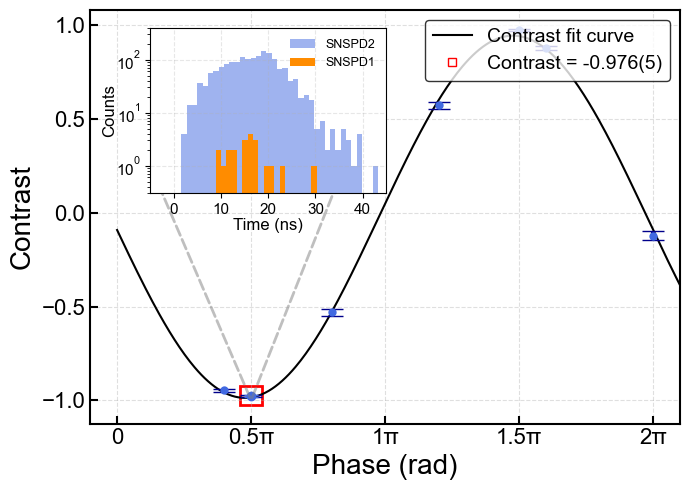

In [79]:
# fig 2d

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
out_csv='gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
x_data = origin_df["turn"].values
y_data = origin_df["gamma"].values
y_data_err = origin_df["gamma_err"].values

# ===== 1. 定义cos拟合函数 =====
def cos_func(x, A, phi, c):
    return A * np.cos(4*np.pi * x + phi) + c

# 转换横轴为弧度
x_rad = x_data * 720 * np.pi / 180
x_dense_a = np.linspace(0, 2*np.pi, 4000)
x_dense_rad = x_dense_a * 720 * np.pi / 180

p0 = [1,0,0]
popt, pcov = curve_fit(cos_func, x_data, y_data, p0=p0)
A_fit, phi_fit, c_fit = popt
perr = np.sqrt(np.diag(pcov))

print(A_fit, phi_fit, c_fit)
print(perr)
y_fit_d = cos_func(x_dense_a, A_fit, phi_fit, c_fit)

##############################################################################
fig, ax = plt.subplots(figsize=(7,5))
plt.rcParams['font.family'] = 'Arial'

ax.plot(x_dense_rad, y_fit_d, 'k-', label='Contrast fit curve', linewidth=1.5)

# 绘制数据点和误差棒（蓝色）
ax.errorbar(
    x_rad, y_data, yerr=y_data_err,
    fmt='o', markersize=6,
    color='royalblue', 
    ecolor='darkblue',
    mec='none',
    elinewidth=3,
    capsize=8,
    alpha=1,
)

# 找到极值点
idx_max_data = np.argmax(y_data)
idx_min_data = np.argmin(y_data)

# 保证 sigma 正常取值
if np.ndim(y_data_err) == 0:  # 标量
    sigma_max = y_data_err
    sigma_min = y_data_err
else:  # 数组
    sigma_max = y_data_err[idx_max_data]
    sigma_min = y_data_err[idx_min_data]

# x_max, y_max = x_rad[idx_max_data], y_data[idx_max_data]
x_min, y_min = x_rad[idx_min_data], y_data[idx_min_data]

# 自适应圈和矩形大小
x_range = max(x_rad) - min(x_rad)
y_range = max(y_data) - min(y_data)

# circle_radius = 0.04 * x_range   # 圈半径
rect_width = 0.05 * x_range      # 矩形宽度
rect_height = 0.05 * y_range     # 矩形高度

# # 红色圈（max）
# circle_max = plt.Circle((x_max, y_max), circle_radius, color='red', fill=False, lw=2)
# ax.add_patch(circle_max)

# 红色矩形（min）
rect_min = plt.Rectangle((x_min-rect_width/2, y_min-rect_height/2),
                         rect_width, rect_height, edgecolor='red', facecolor='none', lw=2)
ax.add_patch(rect_min)

# # 将 max/min 显示在 legend 中，并加上对应符号
# ax.plot([], [], color='red', marker='o', markerfacecolor='none', linestyle='None',
#         label=f'Max = {y_max:.3f} ± {sigma_max:.3f}')
ax.plot([], [], color='red', marker='s',markerfacecolor='none',  linestyle='None',
        label=f'Contrast = {y_min:.3f}(5)')

# # 绘制原始 marker（蓝色，保持一致）
# ax.errorbar(x_max, y_max, yerr=sigma_max, fmt='o', markersize=6, capsize=5, color='royalblue')
ax.errorbar(x_min, y_min, yerr=sigma_min, fmt='o', markersize=6, capsize=5, color='royalblue')

# 设置纵轴 ticks 和标签
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel("Contrast", fontsize=20)

# 设置横轴为 π 的倍数
xticks = [0,0.5*np.pi, 1*np.pi, 1.5*np.pi, 2*np.pi]
xtick_labels = ['0', '0.5π', '1π', '1.5π', '2π']
ax.set_xlim(-0.1*np.pi, 2.1*np.pi)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel("Phase (rad)", fontsize=20)

# 横纵轴刻度字体大小
ax.tick_params(axis='both', labelsize=16, direction='in', length=6, width=1.5)

# 网格、图例和边框
ax.grid(True, linestyle='--', alpha=0.4)
leg = ax.legend(fontsize=14, frameon=True, loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1)
frame.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# inset plot
axins = inset_axes(ax, width="40%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.09,0.54,1,1), bbox_transform=ax.transAxes)  # 可以调整位置和大小

# 绘制 PMT2
axins.hist(pmt2_hist_ts/1000 - x_offset, bins=50,
           color='royalblue', alpha=0.5, label='SNSPD2',
           edgecolor='none', linewidth=1, zorder=1,log=True)


# 绘制 PMT1
axins.hist(pmt1_hist_ts/1000 - x_offset, bins=50,
           color='darkorange', alpha=1, label='SNSPD1',
           edgecolor='none', linewidth=1, zorder=2,log=True)

# 设置 inset x 轴范围
axins.set_xlim(-5, 45)
axins.set_ylim(0.3, 400)

# 坐标轴标签和刻度
axins.set_xlabel("Time (ns)", fontsize=12,labelpad=1)
axins.set_ylabel("Counts", fontsize=12,labelpad=-1)
axins.tick_params(axis='both', labelsize=11)

# 网格和图例
axins.grid(True, linestyle='--', alpha=0.3)
axins.legend(fontsize=9,frameon=False)

ax.annotate('', xy=(45, 100), xycoords=axins.transData, 
            xytext=(0.5*np.pi, -1), textcoords=ax.transData,
            arrowprops=dict(arrowstyle='-', linestyle = '--', color='gray', lw=2, alpha = 0.5))

# 第二条线段：从大图的点 (7, sin(7)) 指向小图的 (7, -0.5)
ax.annotate('', xy=(-5,1), xycoords=axins.transData,
            xytext=(0.5*np.pi, -1), textcoords=ax.transData,
            arrowprops=dict(arrowstyle='-', linestyle = '--',color='gray', lw=2, alpha = 0.5))

plt.tight_layout()
# fig.savefig("fig3a.png", dpi=600)
plt.show()

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_13904/4176300355.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


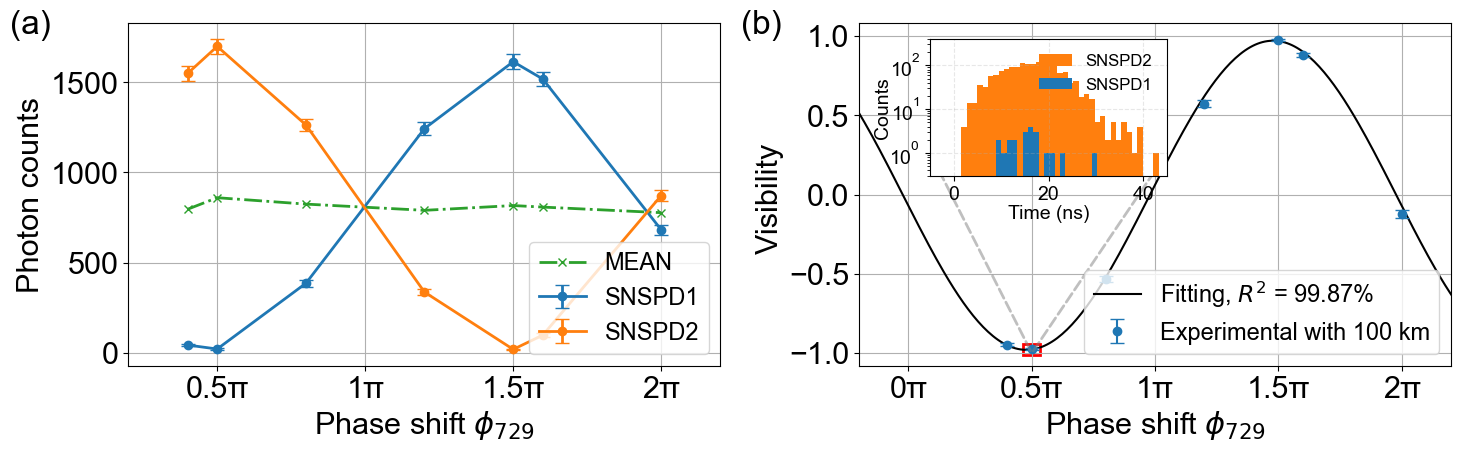

In [160]:
pmt1=origin_df['pmt1']
pmt2=origin_df['pmt2']
x_data = origin_df['turn']*360*2  # x轴数据
y_data = origin_df['gamma']  # y轴数据
y_err = origin_df['gamma_err']  # y轴数据误差
phase_array=np.linspace(-180,360*2,500)
turn_array=phase_array/360/2
origin_fit=model_func_count_offset(phase_array,*param_origin)

# 计算R²
mean_y = np.mean(y_data)
total_variance = np.sum((y_data - mean_y) ** 2)
residual_variance = np.sum((y_data - model_func_count_offset(origin_df['turn']*360*2,*param_origin)) ** 2)
r_squared = 1 - (residual_variance / total_variance)

## 字体大小
plt.rcParams.update({
    'font.size': 22,          # 全局默认字体大小
    'axes.titlesize': 20,     # 标题字体大小
    'axes.labelsize': 22,     # 坐标轴标签字体大小
    'xtick.labelsize': 22,    # x轴刻度字体大小
    'ytick.labelsize': 22,    # y轴刻度字体大小
    'legend.fontsize': 17     # 图例字体大小
})
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].errorbar(origin_df['turn']*4,pmt1,fmt='-o',yerr=np.sqrt(pmt1),label='SNSPD1',capsize=5,linewidth=2,color='C0')
axs[0].errorbar(origin_df['turn']*4,pmt2,fmt='-o',yerr=np.sqrt(pmt2),label='SNSPD2',capsize=5,linewidth=2,color='C1')
axs[0].plot(origin_df['turn']*4,(pmt1+pmt2)/2, 'x-.', label='MEAN',linewidth=2,color='C2')
# axs[0].set_xlim(0,360*2)
axs[0].set_xlabel('Phase shift $\\phi_{729}$')
axs[0].set_ylabel('Photon counts')
axs[0].legend(loc='lower right')
axs[0].grid()
axs[1].plot(turn_array*4,origin_fit,label='Fitting, $R^2$ = {:.2%}'.format(r_squared),color='k')
axs[1].errorbar(origin_df['turn']*4,origin_df['gamma'],yerr=origin_df['gamma_err'],fmt='o',capsize=5,
             label='Experimental with 100 km',color='C0')
axs[1].set_xlabel('Phase shift $\\phi_{729}$')
axs[1].set_ylabel('Visibility ')
axs[1].set_xlabel('Phase shift $\\phi_{729}$')
# 设置x轴刻度为π的倍数并添加π符号
ticks = np.arange(0, 2+0.2, 1/2)
labels = ['0π', '0.5π', '1π', '1.5π', '2π']
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(labels)
axs[0].set_xlim(0.2,2+0.2)
axs[1].set_xlim(-0.2,2+0.2)
axs[1].set_xticks(ticks)
axs[1].set_xticklabels(labels)
# axs[1].set_xlim(0,360*2)
axs[1].legend(loc='lower right')
axs[1].grid()
## 在 axs[1] 上添加红色矩形框突出显示最低点

# ===== 新增：inset 直方图 =====
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# 若变量不存在可在此添加安全检查
if 'pmt1_hist_ts' in globals() and 'pmt2_hist_ts' in globals():
    axins = inset_axes(axs[1], width="40%", height="40%", loc='lower left',
                       bbox_to_anchor=(0.1,0.52,1,1), bbox_transform=axs[1].transAxes)
    axins.hist(pmt2_hist_ts/1000 - x_offset, bins=50,
               color='C1', alpha=1, label='SNSPD2', edgecolor='none', linewidth=1, log=True)
    axins.hist(pmt1_hist_ts/1000 - x_offset, bins=50,
               color='C0', alpha=1, label='SNSPD1', edgecolor='none', linewidth=1, log=True)
    axins.set_xlim(-5,45)
    axins.set_ylim(0.3,400)
    #设置label 字体大小
    axins.set_xlabel("Time (ns)", fontsize=14, labelpad=1)
    axins.set_ylabel("Counts", fontsize=14, labelpad=-2)
    axins.tick_params(axis='both', labelsize=14)
    axins.grid(True, linestyle='--', alpha=0.3)
    # 只在主图显示综合图例，不在 inset 内显示
    axins.legend(fontsize=12, frameon=False)
    ## 在 axs[1] 增加红色矩形框突出显示最低点
    axs[1].annotate('', xy=(45, 1), xycoords=axins.transData, 
            xytext=(0.125*4, -1), textcoords=axs[1].transData,
            arrowprops=dict(arrowstyle='-', linestyle = '--', color='gray', lw=2, alpha = 0.5))

    # 第二条线段：从大图的点 (7, sin(7)) 指向小图的 (7, -0.5)
    axs[1].annotate('', xy=(-5,1), xycoords=axins.transData,
                xytext=(0.125*4, -1), textcoords=axs[1].transData,
                arrowprops=dict(arrowstyle='-', linestyle = '--',color='gray', lw=2, alpha = 0.5))
    x_min, y_min = 0.5, origin_df['gamma'].min()
    rect_width, rect_height = 0.07, 0.07
    rect_min = plt.Rectangle((x_min-rect_width/2, y_min-rect_height/2),
                         rect_width, rect_height, edgecolor='red', facecolor='none', lw=2)
    axs[1].add_patch(rect_min)
else:
    print("缺少 pmt1_hist_ts / pmt2_hist_ts 变量，先运行之前的直方图单元格。")
## 每张图左边增加(a)、(b)
axs[0].text(-0.2, 1.04, '(a)', transform=axs[0].transAxes, fontsize=24, va='top')
axs[1].text(-0.2, 1.04, '(b)', transform=axs[1].transAxes, fontsize=24, va='top')



plt.tight_layout()
plt.savefig('SM_visibliy_char.pdf',dpi=1000)